In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hurry.filesize import size, si
import re

sns.set_style("whitegrid")

In [583]:
FIG_PARAMS = dict(
    fig_size=(14, 5),
    label_size=20,
    legend_size=14,
    legend_title_size=17,
    title_size=26,
    annot_size=16,
    tick_size=16,
    marker_size=2,
    fill_alpha=0.15,
)

FIG_PARAMS_HEATMAP = dict(
    fig_size=(12, 8),
    label_size=20,
    legend_size=14,
    legend_title_size=17,
    title_size=26,
    annot_size=16,
    tick_size=16,
    marker_size=2,
    fill_alpha=0.15,
)


X_NAMES = {
    "representation": "Represetation type",
    "model": "Model type"
}

Y_NAMES = {
    "fscore": "$F_1$",
    "mae": "$MAE$",
    "inference_mean_time": "Inference time\n[$ms$]",
    "inference_time": "Inference time\n[$ms$]",
    "memory_complexity": "Memory complexity\n[$bytes$]"
}

rep2name = {
    "whole_signal_waveforms": "Whole signal/nwaveforms",
    "whole_signal_features": "Whole signal/nfeatures",
    "agg_beat_waveforms": "Aggregated beat/nwaveforms",
    "agg_beat_features": "Aggregated beat/nfeatures",
}

rep2name_for_table = {
    "whole_signal_waveforms": "WSW",
    "whole_signal_features": "WSF",
    "agg_beat_waveforms": "ABW",
    "agg_beat_features": "ABF",
}

model2name = {
    "LGBM": "LGBM",
    "Regression": "Reg",
    "Decision Tree": "DT",
    "CNN": "CNN",
    "MLP": "MLP"
}

# **Load results csv to df**

In [578]:
results = pd.read_csv("results_3.csv")
drop_cols = ["Name", "State", "Created", "Runtime", "test/auroc", "val/fscore", "val/auroc", "fit_time", "inference_std_time", "val/mae"]
rename_cols = {"test/fscore": "fscore", "test/mae": "mae", "inference_mean_time": "inference_time"}
results = results.drop(drop_cols, axis=1).rename(columns=rename_cols)
results['representation'] = results['representation'].apply(lambda rep: rep2name_for_table[rep])
results['model'] = results['model'].apply(lambda model: model2name[model])

# **Split results df into different datasets dfs**

In [579]:
ptbxl_results = results.query("dataset == 'ptbxl'").drop("dataset", axis=1).sort_values(by=["model", "representation"])
sleep_edf_results = results.query("dataset == 'sleep_edf'").drop("dataset", axis=1).sort_values(by=["model", "representation"])
mimic_results = results.query("dataset == 'mimic'").drop("dataset", axis=1).sort_values(by=["model", "representation"])

# ptbxl_results['memory_complexity'].apply(lambda size_bytes: size(size_bytes, system=si))

In [485]:
def compare_results(data, x="representation", y="fscore", hue="model", ax=None):    
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=FIG_PARAMS['fig_size'])
        return_fig = True
        
    sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax)
    ax.legend(
        bbox_to_anchor=(1.02, 1), loc='upper left', 
        borderaxespad=0, fontsize=FIG_PARAMS['legend_size'],
        title=X_NAMES[hue],
        title_fontsize=FIG_PARAMS['legend_title_size']
    )
    ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS["label_size"])
    ax.set_ylabel(Y_NAMES[y], fontsize=FIG_PARAMS["label_size"])
    # ax.tick_params(axis="x", labelrotation=15)
    ax.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
    plt.close()
    if return_fig:
        return fig

def get_comparison_figs(results_df, y="fscore", prefix=""):
    params = dict(data=results_df, y=y)
    models_fig = compare_results(x="representation", hue="model", **params)
    representation_fig = compare_results(x="model", hue="representation", **params)
    return {
        f"{prefix}models": models_fig,
        f"{prefix}reps": representation_fig
    }

def plot_results_heatmap(results_df, x="model", y="representation", z="fscore", ax=None):    
    df = results_df.pivot(y, x, z)
    fmt = "" if metric == "memory_complexity" else ".3g"
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2*len(df)))
        return_fig = True
    axx = sns.heatmap(
        df, 
        cmap='coolwarm', 
        annot=True, fmt=fmt, annot_kws={"fontsize": FIG_PARAMS_HEATMAP['tick_size']},
        cbar=True,
        ax=ax, 
        square=False
    )
    cb = axx.collections[0].colorbar
    cb.ax.tick_params(labelsize=FIG_PARAMS_HEATMAP['legend_size'])
    cb.ax.set_title(get_y_name(z), fontsize=FIG_PARAMS_HEATMAP['legend_title_size'])

    ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS_HEATMAP["label_size"])
    ax.set_ylabel(X_NAMES[y], fontsize=FIG_PARAMS_HEATMAP["label_size"])
    ax.tick_params(axis="x", labelrotation=15)
    ax.tick_params(axis="y", labelrotation=0)
    ax.tick_params(axis="both", labelsize=FIG_PARAMS_HEATMAP["tick_size"])
    plt.close()
    if return_fig:
        return fig
    
def get_all_heatmaps(results_df, x="model", y="representation", pred_qual_metric="fscore"):
    pred_qual_fig = plot_results_heatmap(results_df, z=pred_qual_metric)
    inference_time_fig = plot_results_heatmap(results_df, z="inference_mean_time")
    memory_complexity_fig = plot_results_heatmap(results_df, z="memory_complexity")
    return {
        f"pred_qual_heatmap": pred_qual_fig,
        f"infer_time_heatmap": inference_time_fig,
        f"mem_comp_heatmap": memory_complexity_fig
    }


def get_all_comparison_figs(results_df, pred_qual_metric="fscore", prefix=""):
    pred_qual_figs = get_comparison_figs(results_df, y=pred_qual_metric, prefix="pred_qual_")
    inference_time_figs = get_comparison_figs(results_df, y="inference_mean_time", prefix="infer_time_")
    memory_complexity_figs = get_comparison_figs(results_df, y="memory_complexity", prefix="mem_comp_")
    heatmaps = get_all_heatmaps(results_df, x="model", y="representation", pred_qual_metric=pred_qual_metric)
    figs = {**pred_qual_figs, **inference_time_figs, **memory_complexity_figs, **heatmaps}
    figs = {f"{prefix}{name}": fig for name, fig in figs.items()}
    return figs

In [345]:
results = pd.read_csv("results_3.csv").drop(["Name", "State", "Created", "Runtime"], axis=1)
results['representation'] = results['representation'].apply(lambda rep: rep2name[rep])

info = [
    ("ptbxl", "fscore", ptbxl_results),
    ("sleep_edf", "fscore", sleep_edf_results),
    ("mimic", "mae", mimic_results),
]

for ds_name, metric, data in info:
    figs = get_all_comparison_figs(data, pred_qual_metric=metric, prefix=f"{ds_name}_")
    for fig_name, fig in figs.items():
        fig.savefig(f"plots/{fig_name}.pdf", bbox_inches="tight")

/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)


In [ ]:
ptbxl_figs = get_all_comparison_figs(ptbxl_results, pred_qual_metric='fscore')
sleep_edf_figs = get_all_comparison_figs(sleep_edf_results, pred_qual_metric='fscore')
mimic_figs = get_all_comparison_figs(mimic_results, pred_qual_metric='mae')

In [607]:
def plot_datasets_comparison(data_to_plot, x="representation", hue="model"):    
    if hue == "model":
        width_ratios = [4, 2, 4]
        order = ["WSW", "WSF", "ABW", "ABF"]
        hue_order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        hue_order = [model2name[model] for model in hue_order]
    else:
        width_ratios = [4, 3, 4]
        order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        order = [model2name[model] for model in order]
        hue_order = ["WSW", "WSF", "ABW", "ABF"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5.), gridspec_kw=dict(width_ratios=width_ratios))
    
    ylabels = []
    for ax, (title_name, data, metric) in zip(axes, data_to_plot):
        sns.barplot(
            data=data, 
            x=x, y=metric, hue=hue, 
            ax=ax, 
            hue_order=hue_order[:2] if title_name == "Sleep-EDF" and hue == "representation"  else hue_order,
            order=order[:2] if title_name == "Sleep-EDF" and hue == "model"  else order,
        )
        ax.get_legend().remove()
        # ax.tick_params(axis="x", labelrotation=15)
        ax.set_title(title_name, fontsize=FIG_PARAMS['title_size'])
        ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS['label_size'])
        ax.set_ylabel(Y_NAMES[metric], fontsize=FIG_PARAMS['label_size'])
        ylabels.append(Y_NAMES[metric])
        ax.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])

    lines, labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 1.09), loc='upper center', ncol=8, fontsize=FIG_PARAMS['legend_size'])#, title=X_NAMES[hue])
    axes[0].set_xlabel("")
    axes[2].set_xlabel("")
    
    if len(set(ylabels)) == 1:
        axes[1].set_ylabel("")
        axes[2].set_ylabel("")

    plt.tight_layout()
    return fig

# **Prediction quality plots**

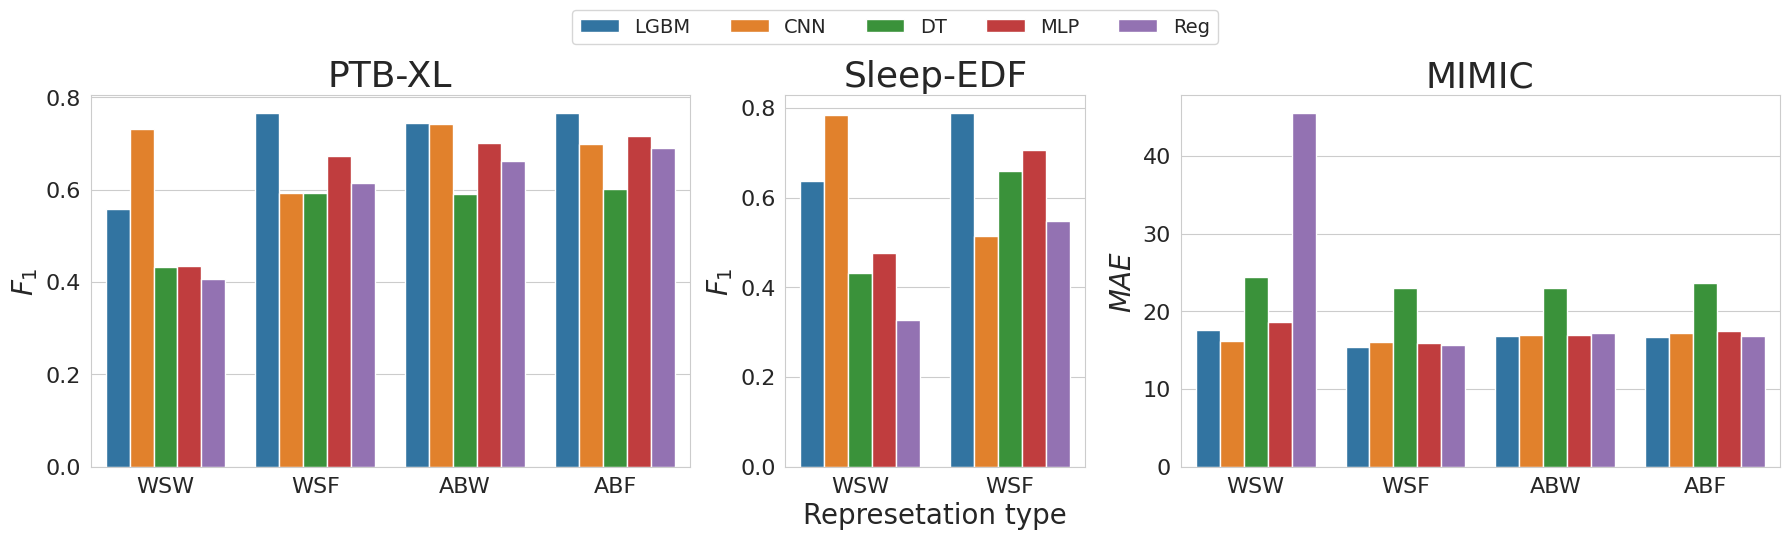

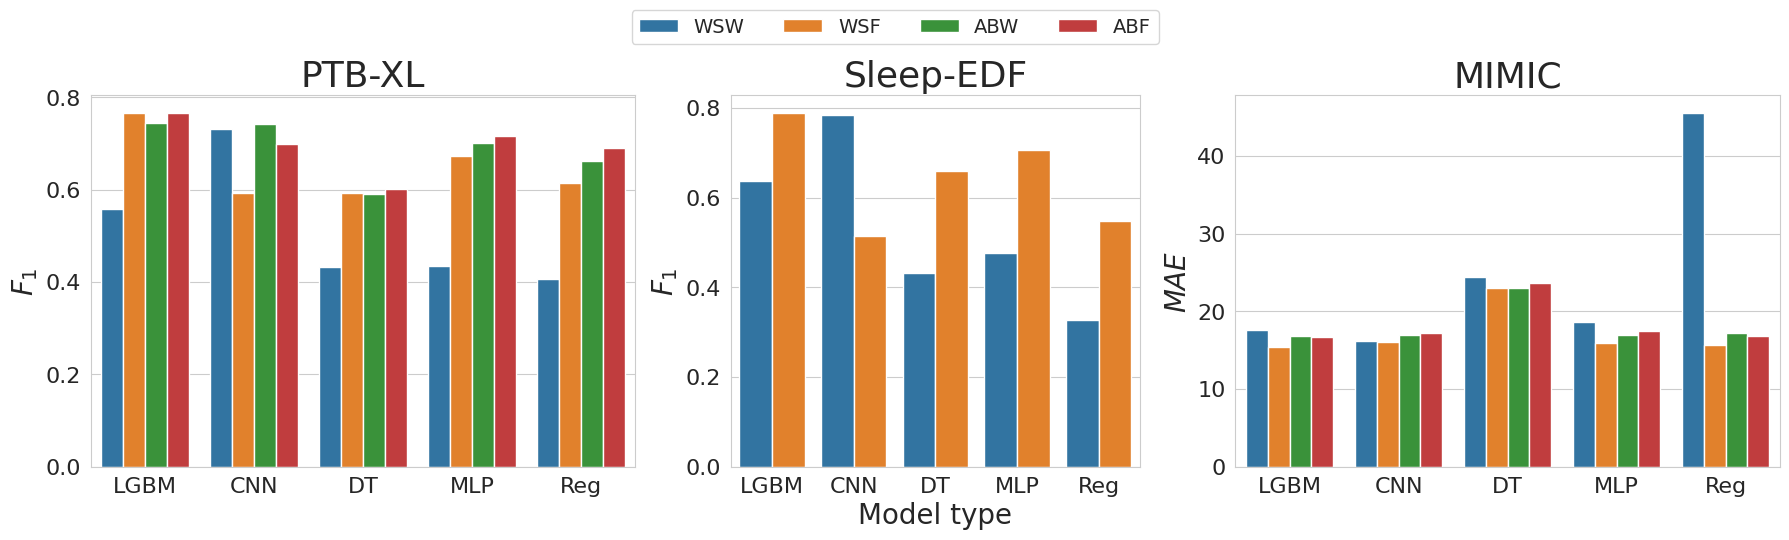

In [608]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "fscore"),
    ("Sleep-EDF", sleep_edf_results, "fscore"),
    ("MIMIC", mimic_results, "mae"),
]

pred_qual_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model")
pred_qual_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation")

# **Inference time**

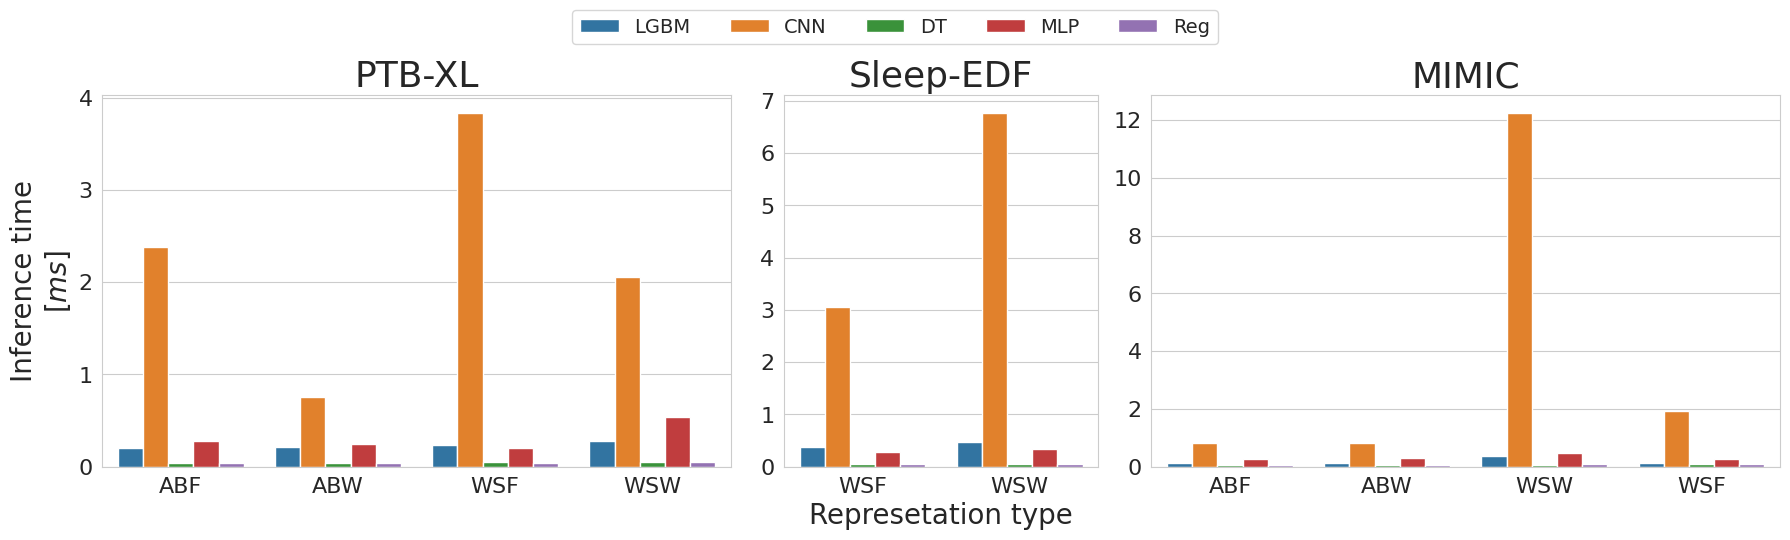

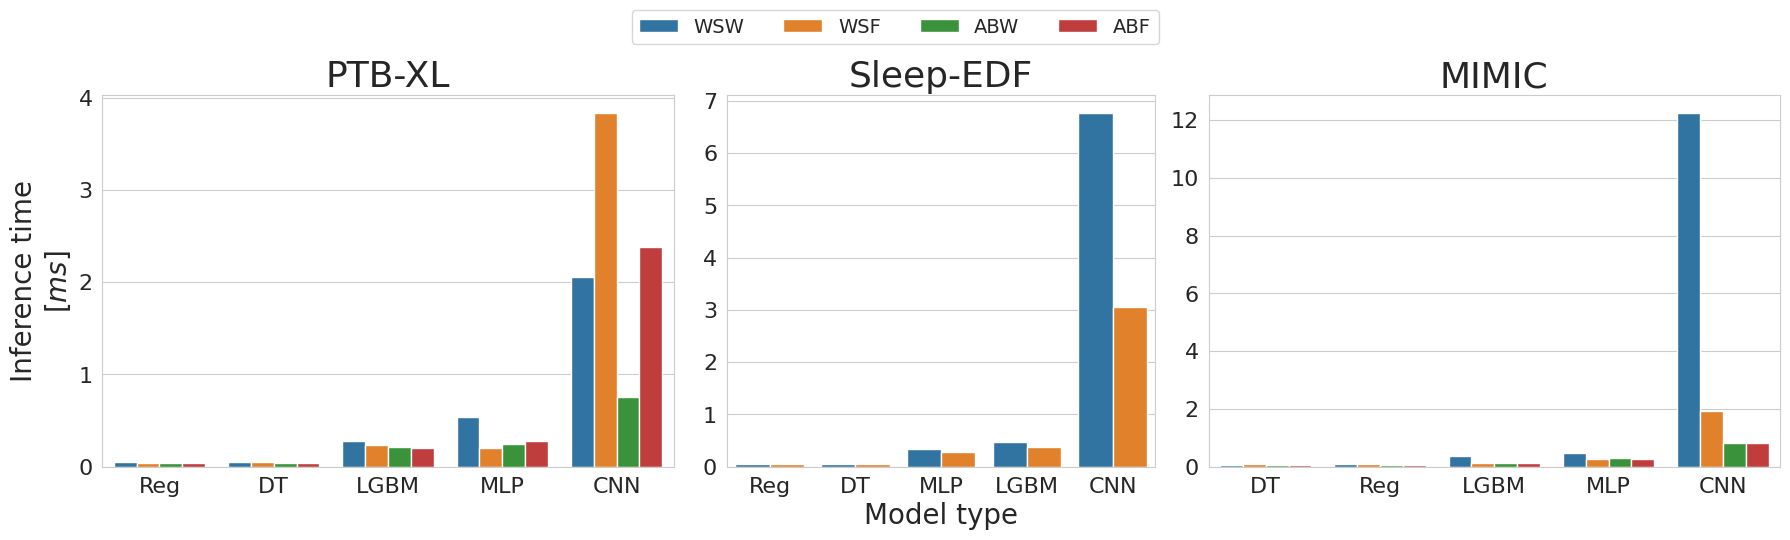

In [594]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "inference_time"),
    ("Sleep-EDF", sleep_edf_results, "inference_time"),
    ("MIMIC", mimic_results, "inference_time"),
]

inference_time_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model")
inference_time_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation")

# **Memory complexity**

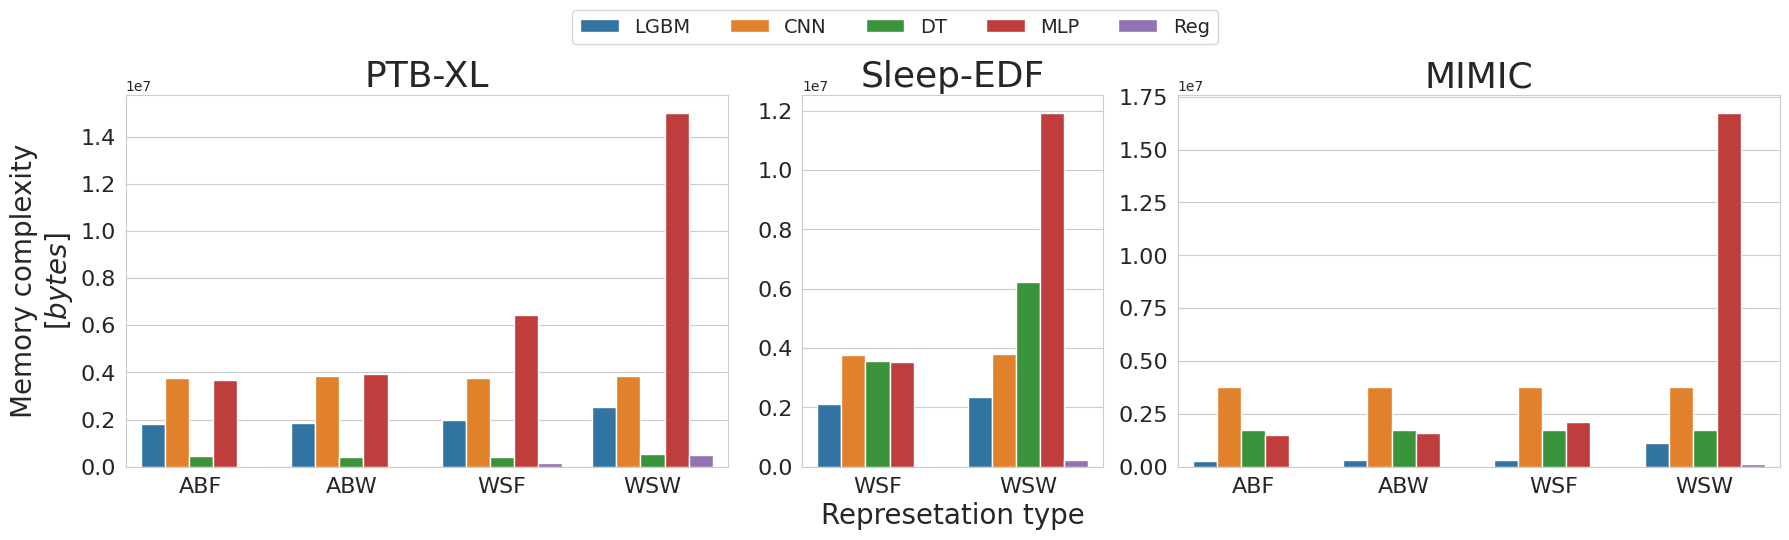

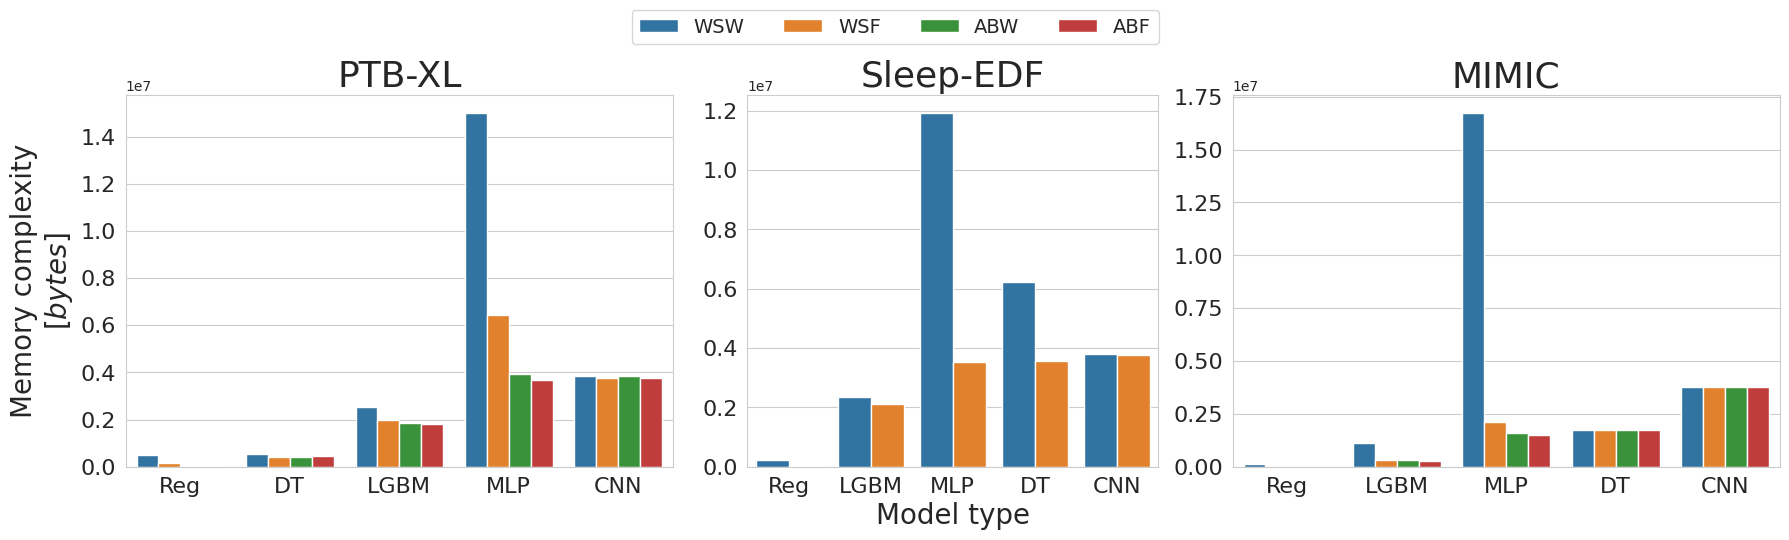

In [595]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "memory_complexity"),
    ("Sleep-EDF", sleep_edf_results, "memory_complexity"),
    ("MIMIC", mimic_results, "memory_complexity"),
]

memory_complexity_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model")
memory_complexity_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation")

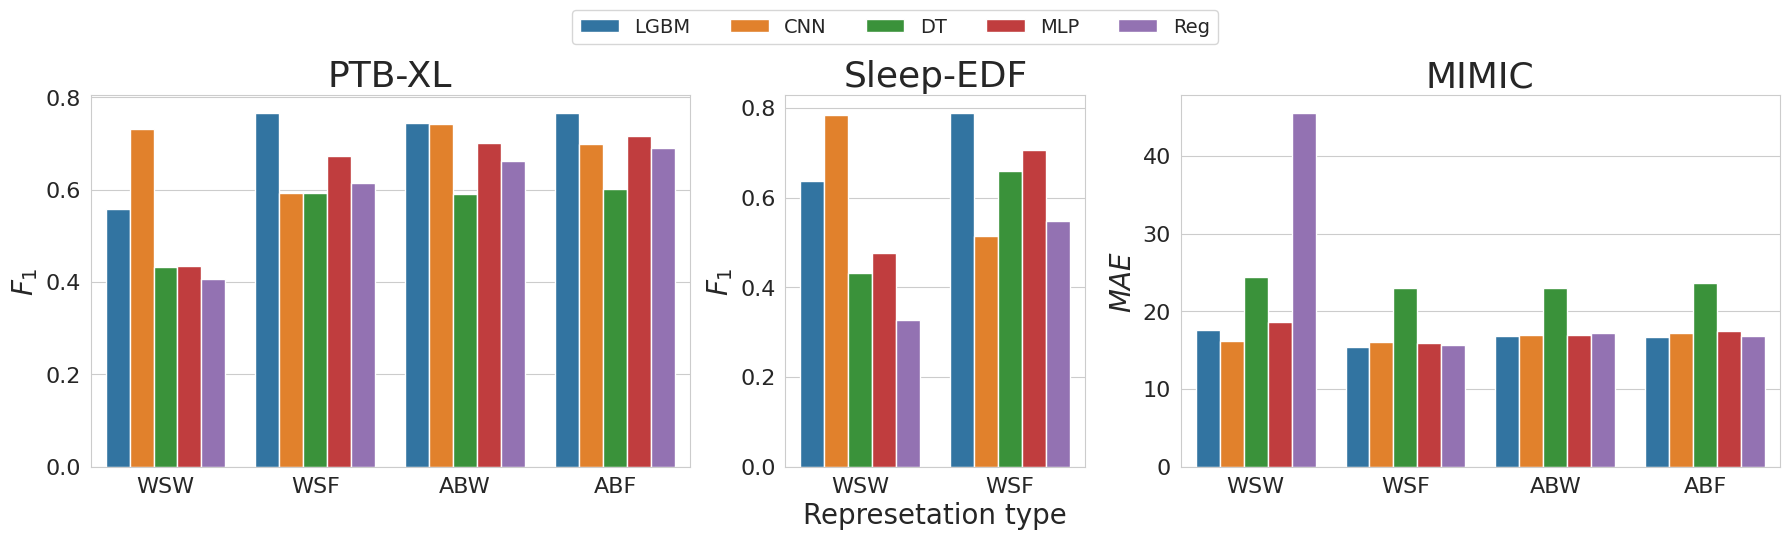

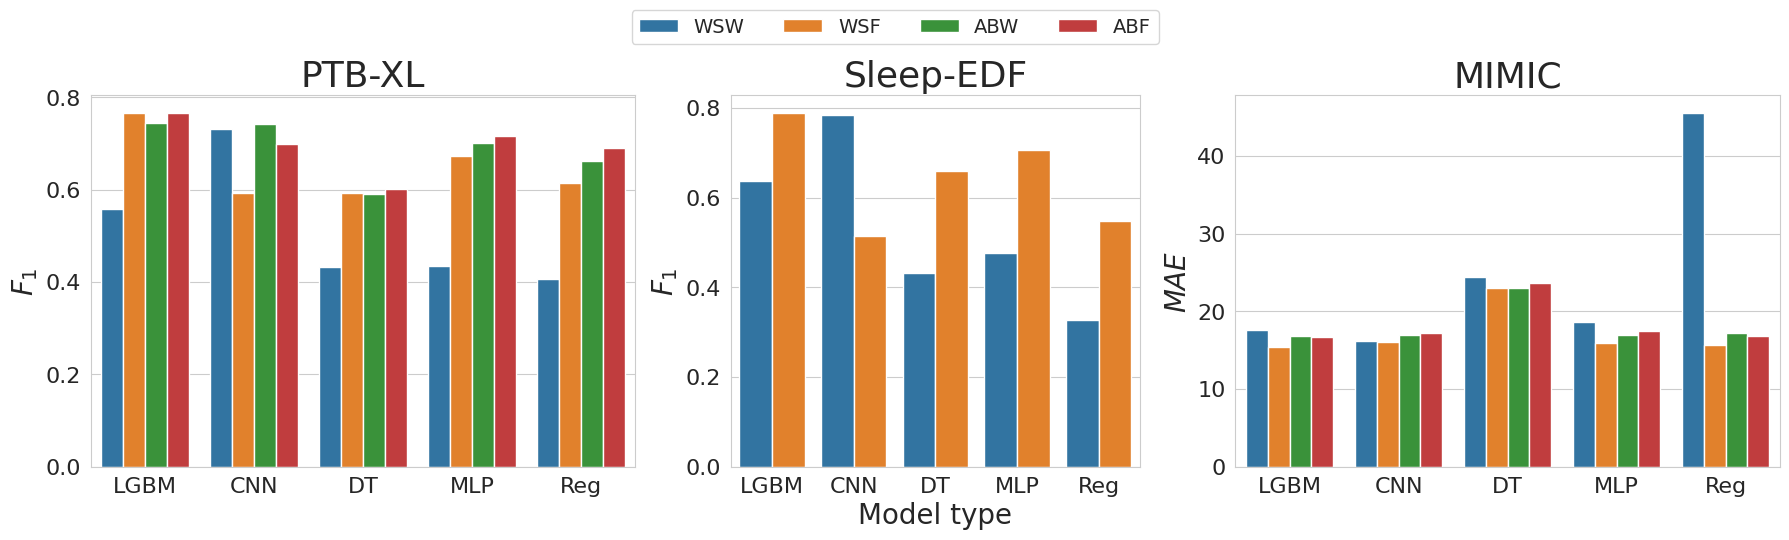

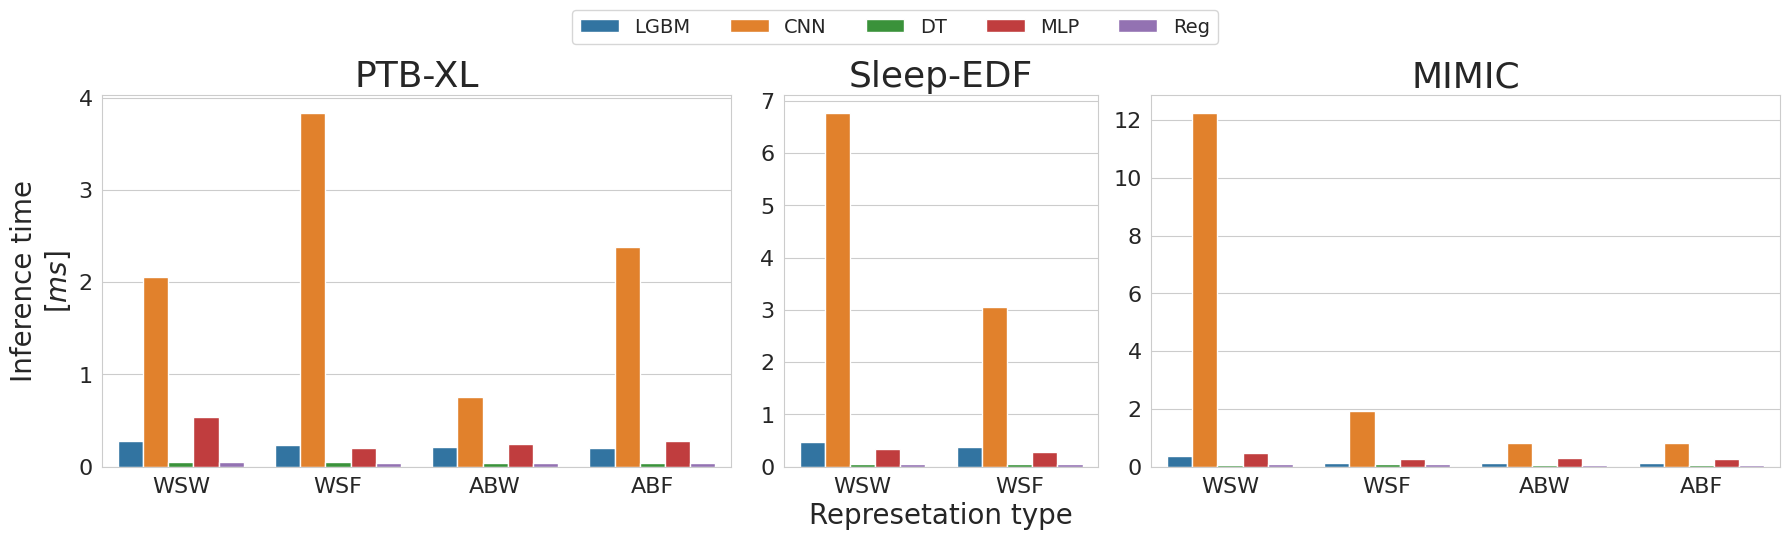

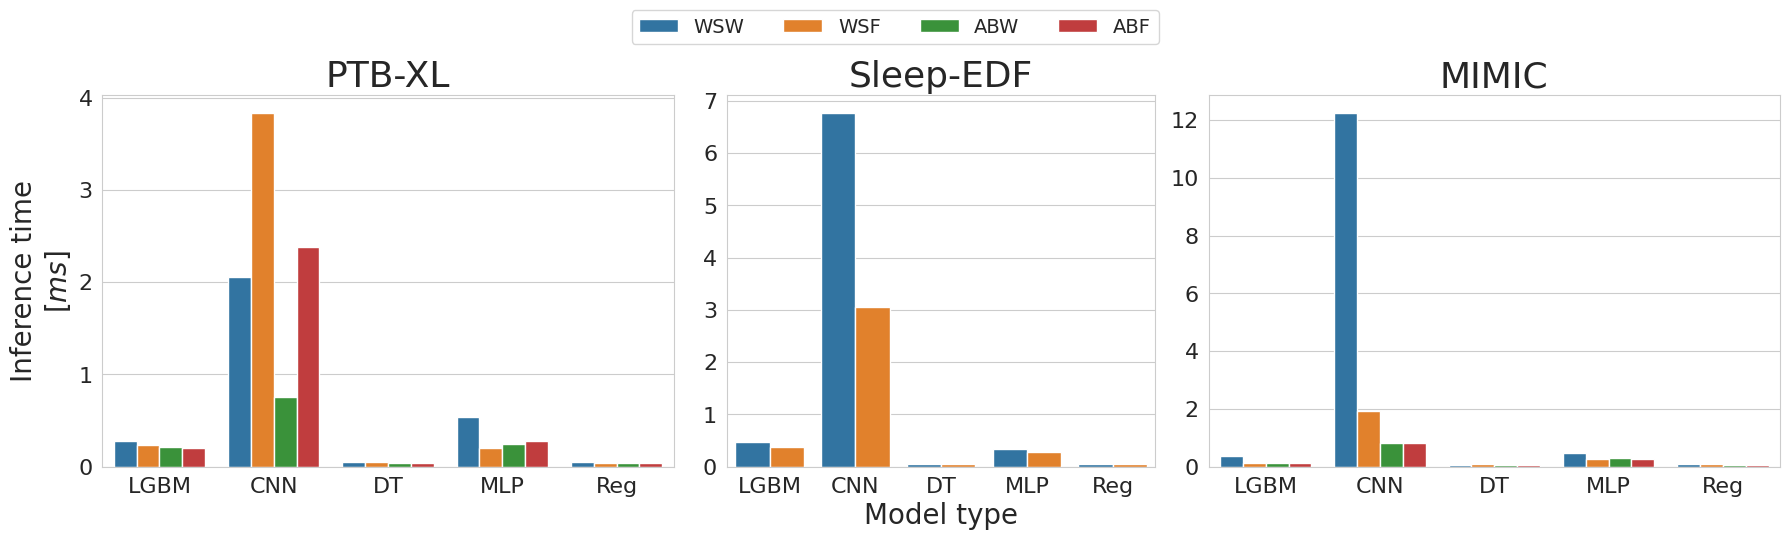

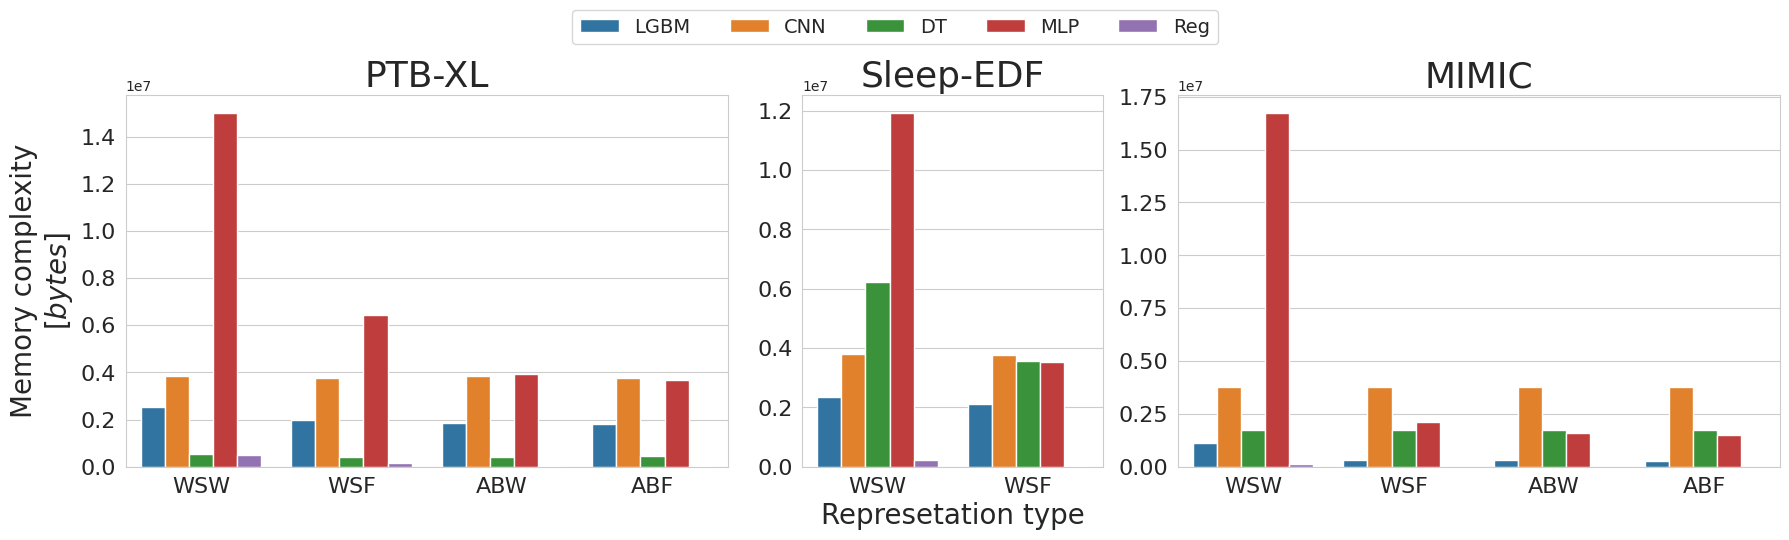

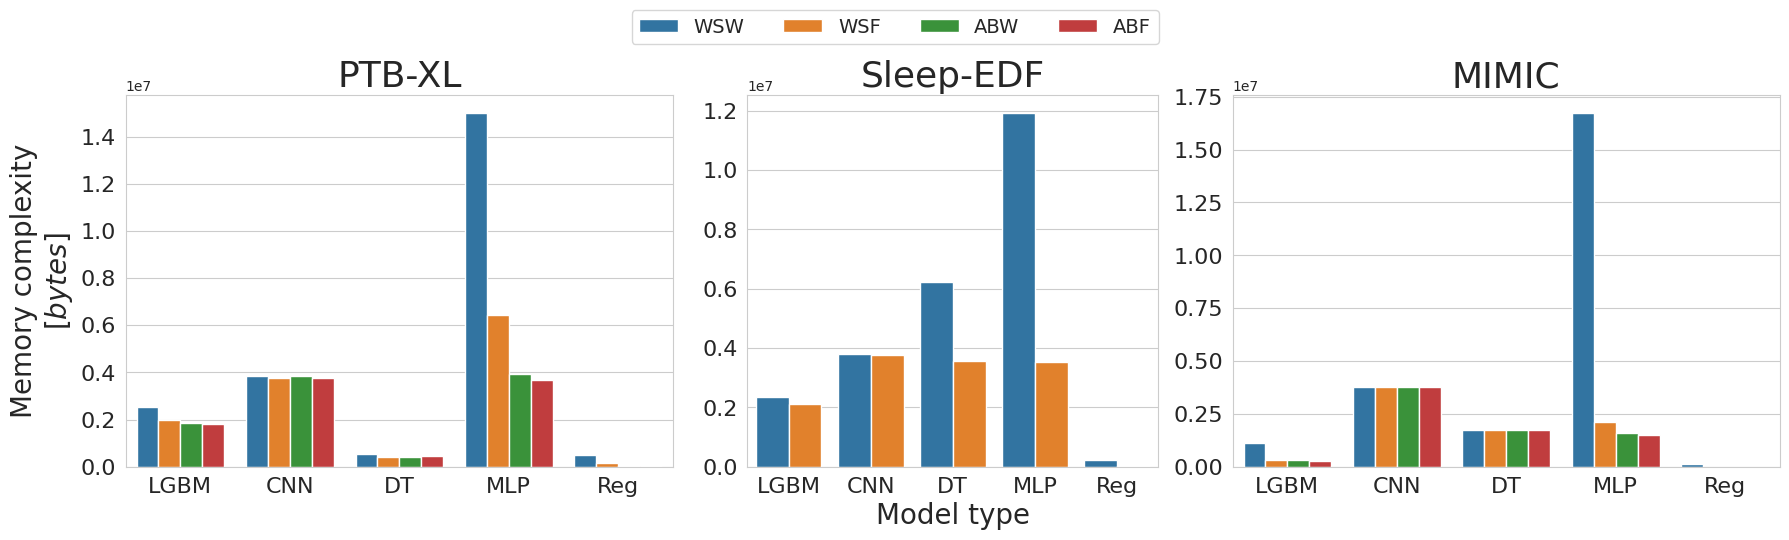

In [609]:
ptbxl_data = ["PTB-XL", ptbxl_results]
sleep_edf_data = ["Sleep-EDF", sleep_edf_results]
mimic_data = ["MIMIC", mimic_results]

pred_qual_plot_data = [ptbxl_data + ["fscore"], sleep_edf_data + ["fscore"], mimic_data + ["mae"]]
inference_time_plot_data = [data + ["inference_time"] for data in [ptbxl_data, sleep_edf_data, mimic_data]]
memory_complexity_plot_data = [data + ["memory_complexity"] for data in [ptbxl_data, sleep_edf_data, mimic_data]]

pred_qual_model_figs = plot_datasets_comparison(pred_qual_plot_data, x="representation", hue="model")
pred_qual_reps_figs = plot_datasets_comparison(pred_qual_plot_data, x="model", hue="representation")
inference_time_model_figs = plot_datasets_comparison(inference_time_plot_data, x="representation", hue="model")
inference_time_reps_figs = plot_datasets_comparison(inference_time_plot_data, x="model", hue="representation")
memory_complexity_model_figs = plot_datasets_comparison(memory_complexity_plot_data, x="representation", hue="model")
memory_complexity_reps_figs = plot_datasets_comparison(memory_complexity_plot_data, x="model", hue="representation")

figs = {
    'pred_qual_model': pred_qual_model_figs,
    'pred_qual_reps': pred_qual_reps_figs,
    
    'inference_time_model': inference_time_model_figs,
    'inference_time_reps': inference_time_reps_figs,
    
    'memory_complexity_model': memory_complexity_model_figs,
    'memory_complexity_reps': memory_complexity_reps_figs,
}

for fig_name, fig in figs.items():
    fig.savefig(f"plots/{fig_name}.pdf", bbox_inches="tight")

# **Results tables**

In [314]:
results['memory_complexity'] = results['memory_complexity'].apply(lambda byte_size: size(byte_size, system=si))
df.rename(
    columns={
        "inference_mean_time": "Inference time [$ms$]",
        "memory_complexity": "Memory complexity [$bytes$]",
        "test/fscore": "F1", 
        "test/mae": "MAE"
    },
    inplace=True
)
df = df.set_index(["dataset", "model", "representation"])[["F1", "MAE", "Inference time [$ms$]", "Memory complexity [$bytes$]"]].sort_index()

In [318]:
ptbxl_df = df.loc['ptbxl'].drop("MAE", axis=1)
sleep_edf_df = df.loc['sleep_edf'].drop("MAE", axis=1)
mimic_df = df.loc['mimic'].drop("F1", axis=1)

In [319]:
def get_latex_table(df):
    latex_table = df.to_latex().replace("NaN", "-").replace('\$', '$')
    latex_table =  re.sub(' +', ' ', latex_table)
    return latex_table

In [320]:
ptbxl_table = get_latex_table(ptbxl_df)
sleep_edf_table = get_latex_table(sleep_edf_df)
mimic_table = get_latex_table(mimic_df)

/tmp/ipykernel_1489004/3237524066.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex().replace("NaN", "-").replace('\$', '$')


In [308]:
print(ptbxl_table)

\begin{tabular}{llrrl}
\toprule
 & & F1 & Inference time [$ms$] & Memory complexity [$bytes$] \\
model & representation & & & \\
\midrule
DT & WSW & 0.432 & 0.049 & 527K \\
CNN & ABF & 0.698 & 2.378 & 3M \\
 & ABW & 0.743 & 0.754 & 3M \\
 & WSF & 0.592 & 3.834 & 3M \\
 & WSW & 0.730 & 2.056 & 3M \\
MLP & ABF & 0.715 & 0.275 & 3M \\
 & ABW & 0.701 & 0.247 & 3M \\
 & WSF & 0.673 & 0.207 & 6M \\
 & WSW & 0.436 & 0.536 & 14M \\
Regression & ABF & 0.690 & 0.037 & 38K \\
 & ABW & 0.663 & 0.041 & 48K \\
 & WSF & 0.615 & 0.044 & 146K \\
 & WSW & 0.407 & 0.055 & 480K \\
DT & ABF & 0.600 & 0.037 & 436K \\
 & ABW & 0.590 & 0.039 & 432K \\
 & WSF & 0.592 & 0.054 & 399K \\
LGBM & ABF & 0.765 & 0.202 & 1M \\
 & ABW & 0.744 & 0.218 & 1M \\
 & WSF & 0.766 & 0.239 & 1M \\
 & WSW & 0.558 & 0.277 & 2M \\
\bottomrule
\end{tabular}

